In [1]:
import env
import numpy as np
import agents_gpu as agents
import copy
import torch as tr
from torch import nn
from matplotlib import pyplot as plt

C:\Users\NiSz\Anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step training: initialization

In [647]:
%%time
sa = agents.StepAgent(lr = 0.1, state_shape = (11, 11, 3))
batch_size = 128
n_runs = 1000

Wall time: 5.37 ms


## Run training

In [59]:
%%time
rewardss = []
ws = []
for i in range(n_runs):
    envs = [env.GridWorld(size = 11, n_target = 4) for i in range(batch_size)]
    ws.append(copy.deepcopy(sa.policy.fc.weight))
    obs = np.zeros([batch_size, 2, 11, 11, 4])
    for ie, e in enumerate(envs):
        e.reset()
        obs[ie] = e.observe()
    states = obs[:, 0, :, :, :3].transpose([0, 3, 1, 2])
    re = []
    for istep in range(25):
        act = sa.act(states)
        
        obs = np.zeros([batch_size, 2, 11, 11, 4])
        rewards = np.zeros([batch_size])
        dones = np.zeros([batch_size])
        for ie, e in enumerate(envs):
            _obs, reward, done = e.step([act[ie, 0].item(), 0])
            obs[ie,:,:,:,:] = _obs
            rewards[ie] = reward
            dones[ie] = done
        states = obs[:, 0, :, :, :3].transpose([0, 3, 1, 2]).copy()
        re.append(np.mean(rewards))
        
        sa.reward(rewards, states, dones)
        sa.train()
    sa.reset()
    rewardss.append(np.sum(re))
tr.save(sa.policy.state_dict(), 'valuenetdict_step_deep.pt')

Wall time: 20min 18s


## Training stats

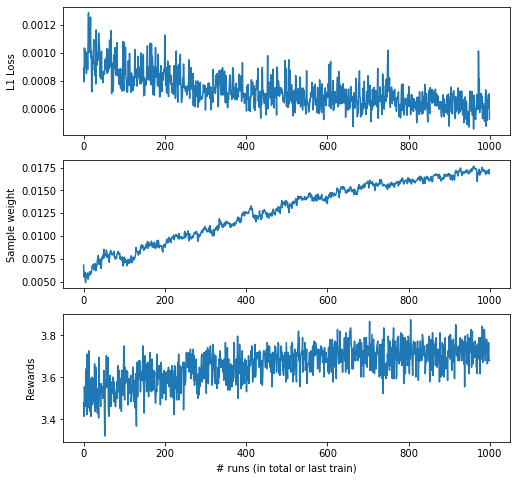

In [646]:
plt.figure(figsize=[8,8])
plt.subplot(3,1,1)
plt.plot(np.array(sa.loss).reshape([-1, 25]).mean(1))
plt.ylabel("L1 Loss")
#plt.ylim([-0,0.001])
plt.subplot(3,1,2)
plt.plot([ws[i][4,6].item() for i in range(len(rewardss))])
plt.ylabel("Sample weight")
plt.subplot(3,1,3)
plt.plot(rewardss)
plt.ylabel("Rewards")
plt.xlabel("# runs (in total or last train)")
plt.savefig("loss.svg")

## load trained net

In [4]:
sa = agents.StepAgent(lr = 0.1, state_shape = (11, 11, 3))
sa.loadnet(tr.load('valuenetdict_step_deep.pt'))

## try to run a random env step by step

In [616]:
# initialize the random env
envs = env.GridWorld(size = 11, n_target = 4)

In [636]:
# each run of this cell is a step
try:  
    obs[0,:,:,:,:] = _obs
except:
    obs = np.zeros([1, 2, 11, 11, 4])
states = np.zeros([1, 3,11, 11])
states[:] = obs[:, 0, :, :, :3].transpose([0, 3, 1, 2]).copy()
# acts.append(act)
obs[0] = np.zeros([1, 2, 11, 11, 4])
act = sa.act(tr.tensor(states).float().cuda())
_obs, reward, done = envs.step([act[0, 0].item(), 0])
prs = sa.policy(tr.tensor(states).float().cuda())
print(envs)
print(prs)
print(act)
#_obs, reward, done = envs[ie].step([4, 0])
prs = sa.policy(tr.tensor(states).float().cuda())

  # # # # # # # # # # # 
  #                 1 # 
  #                   # 
  #                   # 
  #       2           # 
  #                 # # 
  #                 # # 
  #                   # 
  #               #   # 
  #               #   # 
  # # # # # # # # # # #  
tensor([[-0.3678,  0.2227,  0.1553,  0.0495,  0.2080]], device='cuda:0',
       grad_fn=<MmBackward0>)
tensor([[1]], device='cuda:0')
